**Install requirements**

In [ ]:
# !pip3 install 'torch==1.3.1'
# !pip3 install 'torchvision==0.5.0'
# !pip3 install 'Pillow-SIMD'
# !pip3 install 'tqdm'

**Import libraries**

In [1]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader 
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torchvision.models import vgg16
from torchvision.models import resnet50

from PIL import Image
from tqdm import tqdm
import copy
import time

**Set Arguments**

In [2]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 101    # 101: 'BACKGROUND_Google' class removed 


NETWORK_TYPE = 'alexnet'        # Available networks: 'alexnet', 'vgg', 'resnet'
BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic 
                     # suggests that, when changing the batch size, learning rate should change by 
                     # the same factor to have comparable results

if NETWORK_TYPE == 'vgg' or NETWORK_TYPE == 'resnet' : 
  BATCH_SIZE = 16    # with 'vgg' and 'resnet' use lower values suche as BATCH_SIZE = 16 

LR = 1e-3            # The initial Learning Rate 1e-2
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10
PRETRAINED = True        # If 'True' the NETWORK will be pre-trained on ImageNet dataset
FREEZE = 'conv_layers'   # Available choice: 'no_freezing', 'conv_layers', 'fc_layers'
# BEST_NET = False          # Save the best 'snapshot' 

RANDOM = 42
TRAIN_SIZE = 0.5     # split between training and validation sets

**Define Data Preprocessing**

In [3]:
if PRETRAINED : 
  mean, stdev = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
else :
  mean, stdev = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean, stdev) # Normalizes tensor with mean and standard deviation
                                    ])


# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean, stdev)                             
                                    ])

**Prepare Dataset**

In [4]:
from torchvision.datasets import VisionDataset, ImageFolder

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import os
import os.path
import sys

# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/'
from Caltech101.caltech_dataset import Caltech

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.ppm', '.bmp', '.pgm', '.tif', '.tiff', '.webp')

def make_dataset(dir, class_to_idx, extensions=None, is_valid_file=None, split='train', transform='None') : 
    # dir = 'Caltech101'
    images = []
    if not ((extensions is None) ^ (is_valid_file is None)):
        raise ValueError("Both extensions and is_valid_file cannot be None or not None at the same time")
    if extensions is not None:
        def is_valid_file(x):
            return x.lower().endswith(extensions)

    inputFile = os.path.join(dir, split + '.txt') # 'Caltech101/{split}.txt'
    with open(inputFile, 'r') as f:      
      input_images = f.read().splitlines()

    root = os.path.join(dir, '101_ObjectCategories/') # 'Caltech101/101_ObjectCategories/'

    for fname in input_images:
      fpath = os.path.split(fname)
      # print(fpath) # 'accordion' 'image_0002.jpg'
      target = fpath[0] # 'accordion'
      path = os.path.join(root, fname) # 'Caltech101/101_ObjectCategories/accordion/image_0002.jpg'
      if is_valid_file(path) and target != 'BACKGROUND_Google':
        item = (path, class_to_idx[target])
        images.append(item)

    return images # paths

class Caltech(VisionDataset):
    ''' Caltech 101 Dataset '''

    def __init__(self, root, split='train', transform=None, target_transform=None):
        '''
          Args:
            root (string): Directory with all the images.
            split (string): Defines the split you are going to use (split files are called 'train.txt' and 'test.txt').
            transform (callable, optional): Optional transform to be applied on a sample.
            target_transform (callable, optional): Optional trasform to be applied on the target labels (not used).
        '''
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)
        self.split = split
        
        classes, class_to_idx = self._find_classes(self.root)
        samples = make_dataset(self.root, class_to_idx, IMG_EXTENSIONS, split=self.split, transform=transform)
        if len(samples) == 0:
            raise (RuntimeError("Found 0 files in subfolders of: " + self.root + "\n"
                                "Supported extensions are: " + ",".join(extensions)))

        self.loader = pil_loader
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.samples = samples
        self.targets = [s[1] for s in samples]

    def _find_classes(self, dir):        
        root = os.path.join(dir, '101_ObjectCategories/')
        classes = [d.name for d in os.scandir(root) if d.is_dir()]
        classes.remove('BACKGROUND_Google')
        classes.sort()                
        #print(classes)
        class_to_idx = {classes[i]: i for i in range(len(classes))}
        #print(class_to_idx)
        return classes, class_to_idx

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''
        path, label = self.samples[index]
        sample = self.loader(path)

        if self.transform is not None:
            image = self.transform(sample)

        return image, label

    def __len__(self):   
        '''
        The __len__ method returns the length of the dataset
        '''     
        return len(self.samples)


# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# print(f"Training dataset: {train_dataset.__len__()}")
# print(f"Test dataset: {test_dataset.__len__()}")

# Useful variables to plot distribution number of images per category
class_to_idx = train_dataset.class_to_idx
trainlabels = train_dataset.targets 
testlabels = test_dataset.targets
all_labels = trainlabels + testlabels

from sklearn.model_selection import StratifiedShuffleSplit

# split the train_dataset in train and val  
sss = StratifiedShuffleSplit(n_splits=1, train_size=TRAIN_SIZE, random_state=42)

X = [img[0] for img in train_dataset.samples]
y = [lab[1] for lab in train_dataset.samples]

for train_idx, val_idx in sss.split(X,y) :
  train_indexes = train_idx
  val_indexes = val_idx

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)

# Check dataset sizes
print(f"Train Dataset:\t{len(train_dataset)}")
print(f"Valid Dataset:\t{len(val_dataset)}")
print(f"Test Dataset:\t{len(test_dataset)}")

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 12.15 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.
Train Dataset:	2892
Valid Dataset:	2892
Test Dataset:	2893


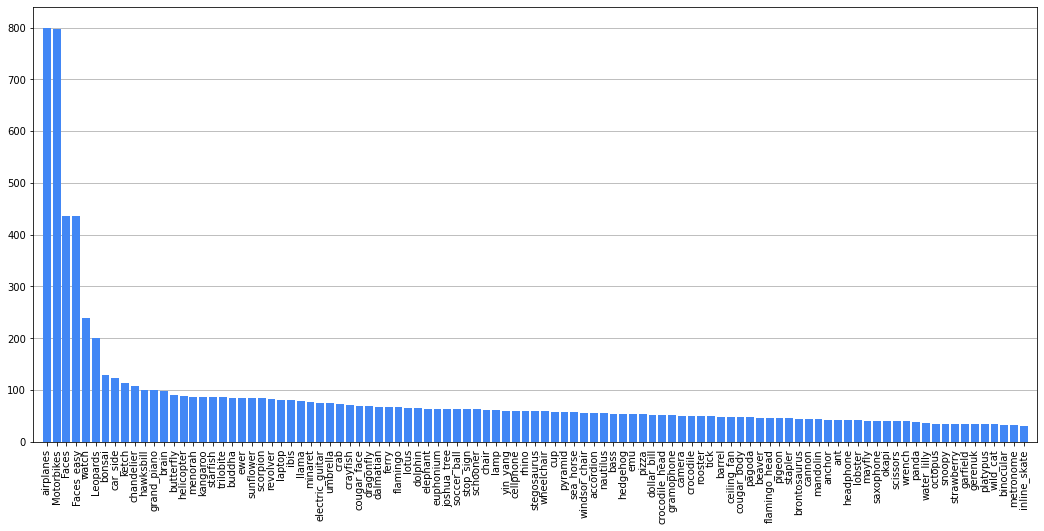

In [ ]:
# Plot distribution number of images per category
from collections import Counter

counter = Counter(all_labels)
count_tuples = counter.most_common()
idx_to_class = {v:k for k,v in class_to_idx.items()}
label_arr = [idx_to_class[target] for target,cnt in count_tuples]
count_arr = [cnt for target,cnt in count_tuples]


plt.figure(figsize=(18, 8))
plt.grid(axis='y',zorder=0)
plt.margins(x=0.01)
plt.bar(label_arr, count_arr, color='#4287f5', align='center', zorder=3)
plt.xticks(rotation='vertical')
plt.show()

**Prepare Dataloaders**

In [5]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Plot some samples**

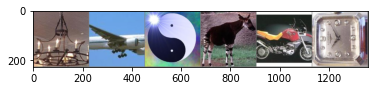

In [ ]:
# Plot some samples
def imgshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return

x, y = next(iter(DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=4, drop_last=True)))
out = torchvision.utils.make_grid(x)
imgshow(out)

**Prepare Network**


In [ ]:
if NETWORK_TYPE == 'alexnet':
  net = alexnet(pretrained=PRETRAINED) # Loading AlexNet model, if pretrained = True, returns a model pre-trained on ImageNet

  # AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
  # We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                   # The convolutional layer is nn.Conv2d
# EXTRA REQUIREMENTS
elif NETWORK_TYPE == 'vgg':
  net = vgg16(pretrained='imagenet')
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

elif NETWORK_TYPE == 'resnet':                                               
  net = resnet50(pretrained=TRANSFER) # If True, returns a model pre-trained on ImageNet
  #net = resnet18(pretrained=TRANSFER)
  num_features = net.fc.in_features
  net.fc = nn.Linear(num_features, NUM_CLASSES)
  NUM_EPOCHS = [10, 10, 10, 10, 10]

# print the chosen network
print(net)

**Prepare Training**

In [7]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize and which one to freeze
if (FREEZE == 'no_freezing'):
  parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet
elif (FREEZE == 'conv_layers'):
  parameters_to_optimize = net.classifier.parameters() # Updates only fully-connected layers (no conv)
elif (FREEZE == 'fc_layers'):
  parameters_to_optimize = net.features.parameters() # Updates only conv layers (no fc)
else :
  raise (ValueError(f"Error Freezing layers (FREEZE = {FREEZE}) \n Possible values are: 'no_freezing', 'conv_layers', 'fc_layers' "))

# Define optimizer
# An optimizer updates the weights based on loss
# SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
# others: 
# optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
# Adam requires a smaller LR otherwise diverge LR <= 1e-3
# optimizer = optim.Adam(parameters_to_optimize, lr=1e-3, betas=(0.9, 0.999), eps=1e-08, weight_decay=WEIGHT_DECAY, amsgrad=False)
# optimzer = optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [8]:
EVAL_ACCURACY_ON_TRAINING = True
criterion_val = nn.CrossEntropyLoss(reduction='sum') # for evaluation I don't want to avg over every minibatch

**Train**

In [ ]:
print("Current Hyperparameters: ")
print(f"N_EPOCHS: {NUM_EPOCHS}")
print(f"STEP_SIZE: {scheduler.step_size}")
print(f"Optimizer: \n{optimizer}")

start = time.time()

# By default, everything is loaded to cpu
net = net.to(DEVICE) # bring the network to GPU if DEVICE is cuda
cudnn.benchmark # Calling this optimizes runtime

# save best config
best_net = 0
best_epoch = 0
best_val_acc = 0.0

# save accuracy and loss
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []

current_step = 0

# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print(f"Starting epoch {epoch+1}/{NUM_EPOCHS}, LR = {scheduler.get_lr()}")
  
  net.train() # Sets module in training mode

  running_corrects_train = 0
  running_loss_train = 0.0

  # Iterate over the training dataset
  for images, labels in train_dataloader:

    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients
  	
    with torch.set_grad_enabled(True):

      # Forward pass to the network
      outputs_train = net(images)

      _, preds = torch.max(outputs_train, 1)

      # Compute loss based on output and ground truth
      loss = criterion(outputs_train, labels)

      # Log loss
      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # store loss and accuracy values
  running_corrects_train += torch.sum(preds == labels.data).data.item() 
  running_loss_train += loss.item() * images.size(0)
  
  train_acc = running_corrects_train / float(len(train_dataset))
  train_loss = running_loss_train / float(len(train_dataset))

  train_accuracies.append(train_acc)
  train_losses.append(train_loss) # loss computed as the average on mini-batches
  #train_loss.append(loss.item()) # loss computed only on the last batch

  ### END TRAINING PHASE OF AN EPOCH

  # Evaluate accuracy on the validation set after each epoch
  net.train(False) # Set Network to evaluation mode

  running_corrects_val = 0
  running_loss_val = 0.0

  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    with torch.set_grad_enabled(False):

      # Forward Pass
      outputs = net(images)

      # Get predictions
      _, preds = torch.max(outputs, 1)

      # Update Corrects
      running_corrects_val += torch.sum(preds == labels.data).data.item()

      # Calculate Loss
      loss = criterion(outputs.data, labels)

    # Update Corrects and Loss
    running_loss_val += loss.item() * images.size(0)
    running_corrects_val += torch.sum(preds == labels.data)

  # Compute epoch loss and accuracy
  val_loss = running_loss_val / float(len(val_dataset))
  val_acc = running_corrects_val / float(len(val_dataset))

  # memorize stats 
  val_losses.append(val_loss)
  val_accuracies.append(val_acc)

  print(f"Validation Accuracy: {val_acc:.4f}")

  # Check if the current epoch val accuracy is better than the best found until now
  if (val_acc >= best_val_acc) : 
    best_val_acc = val_acc
    best_epoch = epoch
    best_net = copy.deepcopy(net) # deep copy the model
  
  # Step the scheduler
  scheduler.step() 

print(f"\nBest epoch: {best_epoch+1}\n{best_val_acc:.4f} (Validation Accuracy)\n")
print(f"> In {(time.time()-start)/60:.2f} minutes")

# audio signal END
beep()

**Validation**

In [26]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print()
print('Validation Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:13<00:00,  1.13s/it]


Validation Accuracy: 0.8253803596127247


**Test**

In [25]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print()
print(f"Test Accuracy: {accuracy}")

100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


Test Accuracy: 0.8354649153128241
